Here I have made a fully automated basic neural network where you can adjust hyperparameters, neural net structure, and activation function without having to tediously rewrite the code. Now it dynamically works with any adjustment. The only think you would need to manually rewrite is the error function, it's derivative and maybe the delta when you start back propagatation. 

In [306]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

In [307]:
df = pd.read_csv('classification-4.csv')
df = df.rename(columns={"target":"target_1"})

In [308]:
df_train,df_test = train_test_split(df, test_size=0.25,random_state=50)

In [309]:
X_train = df_train.drop('target_1',axis=1).values
X_test = df_test.drop('target_1',axis=1).values

y_train = df_train['target_1']
y_test = df_test['target_1']



Graph of test set.

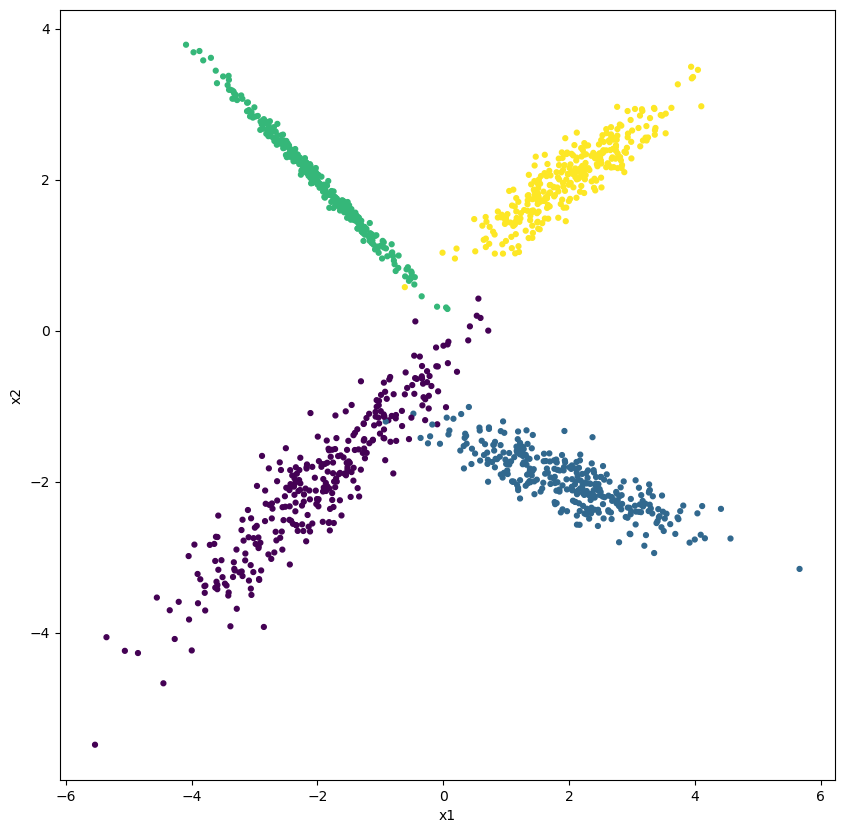

In [310]:
plt.figure(figsize=(10,10))
plt.scatter(df_test['feature_1'],df_test['feature_2'],s=12,c=df_test['target_1'],cmap="viridis")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

One-Hot Encoding.

In [311]:
def onehot(y):
    y = pd.DataFrame(y)
    y["target_1"] = y.iloc[:,0]
    y["target_2"] = y["target_1"]
    y["target_3"] = y["target_1"]
    y["target_4"] = y["target_1"]
    y["target_1"] = np.where(y["target_1"] == 1,1,0)
    y["target_2"] = np.where(y["target_2"] == 2,1,0)
    y["target_3"] = np.where(y["target_3"] == 3,1,0)
    y["target_4"] = np.where(y["target_4"] == 4,1,0)
    return y

y_train = onehot(y_train).values
y_test = onehot(y_test).values

print(X_train.shape)
print(y_train.shape)

(3750, 2)
(3750, 4)


Activation functions and their derivatives.

In [312]:
def lrelu(x,alpha=0.01):
    return np.where(x>0,x,alpha*x)

def lrelu_d(x,alpha=0.01):
    return np.where(x>0,1,alpha)

def softmax(x):
    exp_x = np.exp(x-np.max(x,axis=1,keepdims=True))
    return exp_x / np.sum(exp_x,axis=1,keepdims=True)

Function that configures weights based on the neural structure of the network.

In [ ]:
def weight_configure(input_dim,neurons): #fully automated weight creation based on neuron and layer configuration
    w1 = np.random.randn(input_dim+1, neurons[0])
    weights = []
    for l in range(len(neurons[1:])):
        w = np.random.randn(neurons[l]+1,neurons[l+1])
        weights.append(w)
    return [w1] + weights  


Automated forward propagation function.

In [314]:
def forward(X,weights,activation,activation_o): #fully automated forward prop
    pre_act = []
    act = []
    
    Xc = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)  # this must not be altered
    X_working = Xc.copy()  # this will be altered

    for weight in weights[:-1]: #every weight besides the last
        a = X_working @ weight
        pre_act.append(a)
        X_working = activation(a)
        X_working = np.concatenate([np.ones((X_working.shape[0], 1)),X_working], axis=1) #add bias to the activated function
        act.append(X_working)

    a_final = X_working @ weights[-1] #last weight
    pre_act.append(a_final)
    y = activation_o(a_final)

    return Xc, pre_act, act, y

Automated Backward Propagation function (returns gradients for SGD).

In [315]:
def backward(Xc,pre_act,act,y,t,weights,activation_d): #fully automated backprop
    deltas = []
    dw = []

    delta = y - t #make sure to change this if it's mathematiclly different
    deltas = [delta]
    
    for i in reversed(range(len(weights)-1)):
        W_next = weights[i+1][:-1,:]
        delta = activation_d(pre_act[i]) * (delta @ W_next.T) 
        deltas.insert(0,delta)

    layer_inputs = [Xc] + act[:]
    
    for acts,d in zip(layer_inputs,deltas):
        dw.append(acts.T @ d)
    
    return dw

Stochastic Gradient Descent Function used with mini-batching.

In [316]:
def sgd(weights,gradients,eta):
    new_weights = []
    for W_i, dw_i in zip(weights, gradients):
        newW = W_i - eta*dw_i
        new_weights.append(newW)
    return new_weights

Training loop that combines all of the functions and outputs loss, mean, and optimized weights training through the training set.

In [317]:
def train_mini_batch(X,t,eta,epochs,batch_size,neurons,activation,activation_d,activation_o):
    weights = weight_configure(X.shape[1],neurons)
    N = X.shape[0]
    for epoch in range(epochs):
        indices = np.arange(N)
        np.random.shuffle(indices)
        X = X[indices]
        t = t[indices]

        for i in range(0,N,batch_size):
            X_batch = X[i:i+batch_size]
            t_batch = t[i:i+batch_size]
            Xc, pre_act, act, y = forward(X_batch,weights,activation,activation_o)
            gradients = backward(Xc,pre_act,act,y,t_batch,weights,activation_d)
            weights = sgd(weights,gradients,eta)
        if epoch % 1000 == 0:
            _,_,_,y_full = forward(X,weights,activation,activation_o)
            eps = 1e-8
            loss = -np.mean(np.sum(t * np.log(y_full + eps), axis=1))
            print(f"Epoch {epoch}: Loss = {loss:.6f}, z3 mean = {np.mean(y_full):.4f}")
    return y_full, weights

Hyperparameter adjustment.

The neurons array displays the neural structure of each layer. The first element is the number of neurons in the first hidden layer, and the last element is the number of neurons in the output layer.

activation: Activation function for the hidden layers

activation_d: Derivative of the activation function for the hidden layers

activation_o: Activation function for the output layer

These can be manually adjusted based on what neural network architecture you want. You can add more functions, but you have to manually adjust the code.

In [318]:

######## Hyperparameters ########
eta = 0.001
epochs = 2000
batch_size = 32
neurons = np.array([10,10,10,4])
activation = lrelu
activation_d = lrelu_d
activation_o = softmax
################################

Finalizing the Predictions.

In [319]:
_,o_weights = train_mini_batch(X_train,y_train,eta,epochs,batch_size,neurons,activation,activation_d,activation_o)
_,_,_,y_test_final = forward(X_test,o_weights,activation,activation_o)
y_pred = (y_test_final > 0.5).astype(int)

Epoch 0: Loss = 0.727373, z3 mean = 0.2500
Epoch 1000: Loss = 0.023622, z3 mean = 0.2500


Scoring.

In [320]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#compares predictions with test target values and scores them

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("accuracy: ", accuracy)
print("precision: ",precision)
print("recall", recall)
print("f1:", f1)

accuracy:  0.9928
precision:  0.9929002045093894
recall 0.9928150031624062
f1: 0.9928413431226659


From now on, I will be copying and pasting this model and adjusting/adding to it for other projects. After that I will use built it functions from other libraries, and I will be working on other architectures instead.